In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
import os
os.getcwd()


'/Users/maddi/Documents/secure_genomics_pipeline/notebooks'

In [3]:
#Load dataset
DATA_PATH = "../data/raw/GSE260586_FPKM+1.txt"

In [4]:
df = pd.read_csv(DATA_PATH, sep="\t")
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (25384, 19)
  Chromosome      Start       Stop  Length Strand      Gene Symbol  \
0          X  100627108  100639992   12884      -  ENSG00000000003   
1         20   50934867   50959141   24274      -  ENSG00000000419   
2          1  169849631  169894268   44637      -  ENSG00000000457   
3          1  169662007  169854081  192074      +  ENSG00000000460   
4          1  196651754  196752477  100723      +  ENSG00000000971   

     gene_biotype          gene_id gene_name     gene_source  gene_version  \
0  protein_coding  ENSG00000000003    TSPAN6  ensembl_havana            16   
1  protein_coding  ENSG00000000419      DPM1  ensembl_havana            14   
2  protein_coding  ENSG00000000457     SCYL3  ensembl_havana            14   
3  protein_coding  ENSG00000000460  C1orf112  ensembl_havana            17   
4  protein_coding  ENSG00000000971       CFH  ensembl_havana            17   

       r542     r543     r544     r545      r546      r547     r548     r549  
0  1

In [5]:
#Column 7 is GeneID
gene_column = df.columns[7]

#Set GeneID as index
df = df.set_index(gene_column)

print("After setting GeneID as index:")
print(df.head())

#Drop metadata columns
metadata_rows = ['Chromosome', 'Start', 'Stop', 'Length', 'Strand', 'Gene Symbol', 'gene_biotype', 'gene_name', 'gene_source', 'gene_version']
df = df.drop(columns=metadata_rows)

print(df.head())

print("Dataset shape after dropping metadata columns:", df.shape)


After setting GeneID as index:
                Chromosome      Start       Stop  Length Strand  \
gene_id                                                           
ENSG00000000003          X  100627108  100639992   12884      -   
ENSG00000000419         20   50934867   50959141   24274      -   
ENSG00000000457          1  169849631  169894268   44637      -   
ENSG00000000460          1  169662007  169854081  192074      +   
ENSG00000000971          1  196651754  196752477  100723      +   

                     Gene Symbol    gene_biotype gene_name     gene_source  \
gene_id                                                                      
ENSG00000000003  ENSG00000000003  protein_coding    TSPAN6  ensembl_havana   
ENSG00000000419  ENSG00000000419  protein_coding      DPM1  ensembl_havana   
ENSG00000000457  ENSG00000000457  protein_coding     SCYL3  ensembl_havana   
ENSG00000000460  ENSG00000000460  protein_coding  C1orf112  ensembl_havana   
ENSG00000000971  ENSG0000000097

In [6]:
# Raw QC to catch parsing errors or missing values

# Ensure numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Check for missing values 
print("Missing values:", df.isna().sum().sum()) 

# Check basic stats
print(df.describe())


Missing values: 0
                r542           r543           r544           r545  \
count   25384.000000   25384.000000   25384.000000   25384.000000   
mean       16.607251      18.504421      20.961684      21.888551   
std      1137.172106    1306.252882    1357.799244    1458.233311   
min         1.000000       1.000000       1.000000       1.000000   
25%         1.019468       1.022968       1.004927       1.005810   
50%         1.183840       1.195895       1.098430       1.106940   
75%         1.926220       1.901860       1.656503       1.669678   
max    168503.000000  192207.000000  178888.000000  192484.000000   

               r546           r547           r548          r549  
count  25384.000000   25384.000000   25384.000000  25384.000000  
mean      12.149461      13.162693      24.546437     11.316399  
std      654.511572     821.697578    2090.696472    594.499147  
min        1.000000       1.000000       1.000000      1.000000  
25%        1.013548       1.01

In [7]:
# FPKM data must be log transformed for PCA
log2expr = np.log2(df + 1)  # log2(FPKM + 1) transformation

# Transpose data to have samples as rows and genes as columns
log2expr_T = log2expr.T     

print("Log2 transformed data shape:", log2expr_T.shape )

Log2 transformed data shape: (8, 25384)


Text(0.5, 1.0, 'Log2 expression distribution')

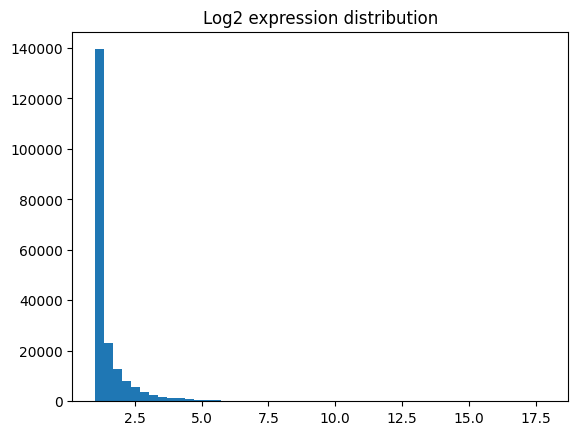

In [8]:
# Post transform QC making sure log transform behaves as expected
plt.hist(log2expr_T.values.flatten(), bins=50)
plt.title("Log2 expression distribution")


In [9]:
# Scale the data
scaler = StandardScaler()
scaled_T = scaler.fit_transform(log2expr_T)

In [10]:
# PCA with multiple components
pca = PCA(n_components=8)
pca_T = pca.fit_transform(scaled_T)

# Explained variance
explained_var = pca.explained_variance_ratio_
print("Explained variance ratios:", pca.explained_variance_ratio_)

Explained variance ratios: [3.28941520e-01 2.53314366e-01 2.29700332e-01 6.51743182e-02
 5.60037595e-02 3.52229453e-02 3.16427592e-02 8.57658705e-31]


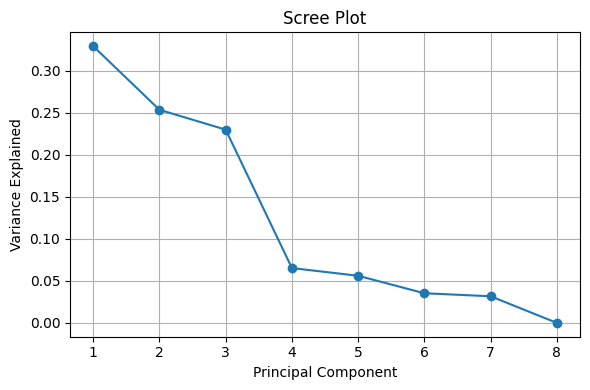

In [11]:
# Create a Scree plot for explained variance
plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.grid(True)
plt.tight_layout()
plt.show()
# Elbow at PC2 suggests using first two PCs for visualization

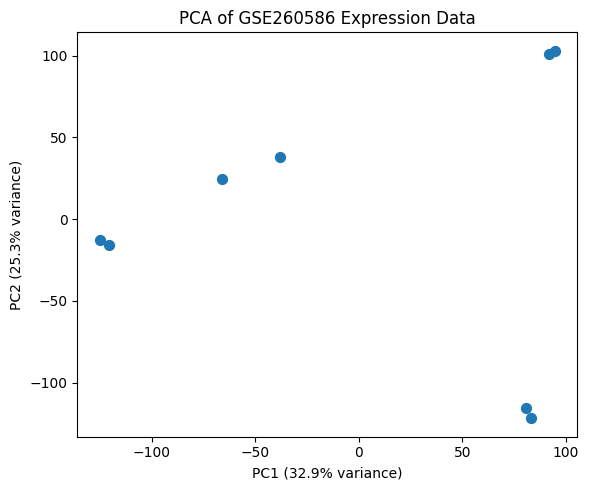

In [12]:
# PCA with 2 components
pca2 = PCA(n_components=2)
pcs2 = pca2.fit_transform(scaled_T)

# Create new DataFrame with PCs
pca_df = pd.DataFrame(data=pcs2, columns=['PC1', 'PC2'], index=log2expr.columns)

# Variance labels
pc1_var = pca2.explained_variance_ratio_[0] * 100
pc2_var = pca2.explained_variance_ratio_[1] * 100   

# Plot 
plt.figure(figsize=(6,5))
plt.scatter(pca_df['PC1'], pca_df['PC2'], s=50)
plt.xlabel(f'PC1 ({pc1_var:.1f}% variance)')
plt.ylabel(f'PC2 ({pc2_var:.1f}% variance)')
plt.title('PCA of GSE260586 Expression Data')
plt.tight_layout()
plt.show()